# All Data EDA

Description of data cleaning before this file:

1. Load, combine, clean credit rating datasets to get unique ratings, company/tickers, and rating issue dates (unique key is credit rating, rating agency, and issuance date). Limit to S&P ratings from 2010-2016.
2. Load and clean dataset of earnings call transcripts, dates, year + quarter of statement releases, companies (unique key is company by earnings call date).
3. Load and clean tabular financial statement datasets (unique key is company, year, quarter).
4. Load and clean company sector dataset (unique key is company).
5. Use earnings call dates to transform dataset of credit ratings so there is one rating at each fixed quarter date (1/1, 4/1, 7/1, 10/1) for each year. The key assumption is that a rating stays the same until a new rating is issued.
6. Inner join earnings call data with credit rating data, retrieving the most recent earnings call. Use year and quarter from earnings calls to inner join with financial statement data. This produces the `all_data_fixed_quarter` dataset.

GitHub copilot suggestions were used for plotting and low-level syntax.

## Setup - Sample Path and Packages

In [109]:
# Flag for if you are running this on the sample dataset
# Sample comprises 100 earnings calls (transcripts included)
# Full data comprises ??? earnings calls (transcripts included)
sample = False
# Modify this path as needed to run on your machine
sample_path = r'~\Box\STAT 222 Capstone\Intermediate Data\All_Data\all_data_fixed_quarter_dates_sample.csv'

In [110]:
# Packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Data Load and Basic Stats

In [111]:
# Load in sample csv, or full parquet file
# Use sample or full data path
if sample:
    df = pd.read_csv(sample_path)
else:
    df = pd.read_parquet(r'~\Box\STAT 222 Capstone\Intermediate Data\All_Data\all_data_fixed_quarter_dates.parquet') 
df

,ticker,fixed_quarter_date,earnings_call_date,Rating,Rating Agency Name,rating_date,Source,Rating Rank AAA is 10,Next Rating,Next Rating Date,...,Change Direction Since Last Fixed Quarter Date,Change Since Last Fixed Quarter Date,Ticker,Description,Company Name,Sector,Industry Group,Industry,Sub-Industry,Comment
0,AAPL,2014-07-01 00:00:00.000000,2014-04-23,AA,Standard & Poor's Ratings Services,2014-05-27,Supplementary,9,AA,2015-02-18,...,None,NaN,AAPL,"Apple Inc. (Apple) designs, manufactures and m...",APPLE INC,Information Technology,Technology Hardware & Equipment,"Technology Hardware, Storage & Peripherals","Technology Hardware, Storage & Peripherals","Manufacturers of cellular phones, personal com..."
1,AAPL,2014-10-01 00:00:00.000000,2014-07-22,AA,Standard & Poor's Ratings Services,2014-05-27,Supplementary,9,AA,2015-02-18,...,Same As Last Fixed Quarter Date,0.0,AAPL,"Apple Inc. (Apple) designs, manufactures and m...",APPLE INC,Information Technology,Technology Hardware & Equipment,"Technology Hardware, Storage & Peripherals","Technology Hardware, Storage & Peripherals","Manufacturers of cellular phones, personal com..."
2,AAPL,2015-01-01 00:00:00.000000,2014-10-20,AA,Standard & Poor's Ratings Services,2014-05-27,Supplementary,9,AA,2015-02-18,...,Same As Last Fixed Quarter Date,0.0,AAPL,"Apple Inc. (Apple) designs, manufactures and m...",APPLE INC,Information Technology,Technology Hardware & Equipment,"Technology Hardware, Storage & Peripherals","Technology Hardware, Storage & Peripherals","Manufacturers of cellular phones, personal com..."
3,AAPL,2015-04-01 00:00:00.000000,2015-01-27,AA,Standard & Poor's Ratings Services,2015-02-18,Supplementary,9,AA,2015-05-28,...,Same As Last Fixed Quarter Date,0.0,AAPL,"Apple Inc. (Apple) designs, manufactures and m...",APPLE INC,Information Technology,Technology Hardware & Equipment,"Technology Hardware, Storage & Peripherals","Technology Hardware, Storage & Peripherals","Manufacturers of cellular phones, personal com..."
4,AAPL,2015-07-01 00:00:00.000000,2015-04-27,AA,Standard & Poor's Ratings Services,2015-06-02,Supplementary,9,AA,2015-08-25,...,Same As Last Fixed Quarter Date,0.0,AAPL,"Apple Inc. (Apple) designs, manufactures and m...",APPLE INC,Information Technology,Technology Hardware & Equipment,"Technology Hardware, Storage & Peripherals","Technology Hardware, Storage & Peripherals","Manufacturers of cellular phones, personal com..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7329,ZTS,2015-10-01 00:00:00.000000,2015-08-04,BBB,Standard & Poor's Ratings Services,2015-01-30,Both,7,BBB,2015-11-03,...,Same As Last Fixed Quarter Date,0.0,ZTS,"Zoetis Inc. is focused on the discovery, devel...",ZOETIS INC,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Pharmaceuticals,Pharmaceuticals,"Companies engaged in the research, development..."
7330,ZTS,2016-01-01 00:00:00.000000,2015-11-03,BBB,Standard & Poor's Ratings Services,2015-11-03,Supplementary,7,BBB,2016-01-22,...,Same As Last Fixed Quarter Date,0.0,ZTS,"Zoetis Inc. is focused on the discovery, devel...",ZOETIS INC,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Pharmaceuticals,Pharmaceuticals,"Companies engaged in the research, development..."
7331,ZTS,2016-04-01 00:00:00.000000,2016-02-16,BBB,Standard & Poor's Ratings Services,2016-01-22,Both,7,BBB,2016-12-23,...,Same As Last Fixed Quarter Date,0.0,ZTS,"Zoetis Inc. is focused on the discovery, devel...",ZOETIS INC,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Pharmaceuticals,Pharmaceuticals,"Companies engaged in the research, development..."
7332,ZTS,2016-07-01 00:00:00.000000,2016-05-04,BBB,Standard & Poor's Ratings Services,2016-01-22,Both,7,BBB,2016-12-23,...,Same As Last Fixed Quarter Date,0.0,ZTS,"Zoetis Inc. is focused on the discovery, devel...",ZOETIS INC,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Pharmaceuticals,Pharmaceuticals,"Companies engaged in the research, developm

In [112]:
# summarize source
df.groupby('source').size()

source
web    7334
dtype: int64

In [113]:
## summary of the raw data 

# Summarize all numeric columns
# use describe method, transpose, and print all rows
# round to two decimal places, no scientific notation, commas for thousands
pd.options.display.float_format = '{:,.2f}'.format
# pandas setting to display all rows
pd.set_option('display.max_rows', None)
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Rating Rank AAA is 10,"7,334.00",6.67,1.00,6.00,7.00,8.00,10.00,1.29
credit_rating_year,"7,334.00","2,013.31","2,010.00","2,012.00","2,013.00","2,015.00","2,016.00",1.59
days_since_call,"7,334.00",57.04,0.00,54.00,61.00,66.00,91.00,14.82
quarter,"7,334.00",2.46,1.00,1.00,2.00,3.00,4.00,1.11
year,"7,334.00","2,013.89","2,010.00","2,013.00","2,014.00","2,015.00","2,016.00",1.53
date_y,7334,2014-06-08 09:14:17.049359104,2010-03-31 00:00:00,2013-03-31 00:00:00,2014-09-27 00:00:00,2015-09-30 00:00:00,2017-04-01 00:00:00,NaN
cik,"7,334.00","768,346.39",0.00,"93,410.00","882,095.00","1,114,448.00","1,845,290.00","528,750.42"
calendarYear,"7,334.00","2,013.89","2,010.00","2,013.00","2,014.00","2,015.00","2,016.00",1.53
period,"7,334.00",2.46,1.00,1.00,2.00,3.00,4.00,1.11
cashAndCashEquivalents,"7,334.00","859,534,237.08","-5,398,000.00","86,919,750.00","326,795,000.00","980,716,500.00","7,719,000,000.00","1,310,200,739.72"


In [114]:
# Revert to default settings
pd.reset_option('display.float_format')
pd.reset_option('display.max_rows')

In [115]:
# Check data is unique on ticker by fixed_quarter_date
df['ticker_fixed_quarter_date'] = df['ticker'] + '_' + df['fixed_quarter_date'].astype(str)
df['ticker_fixed_quarter_date'].value_counts().max()

1

In [116]:
# Number of unique firms (identified by ticker)
df['ticker'].nunique()

536

## Sector

In [117]:
# How often is Sector variable missing?
print('Share of missing values for Sector:', df['Sector'].isna().mean())

Share of missing values for Sector: 0.0


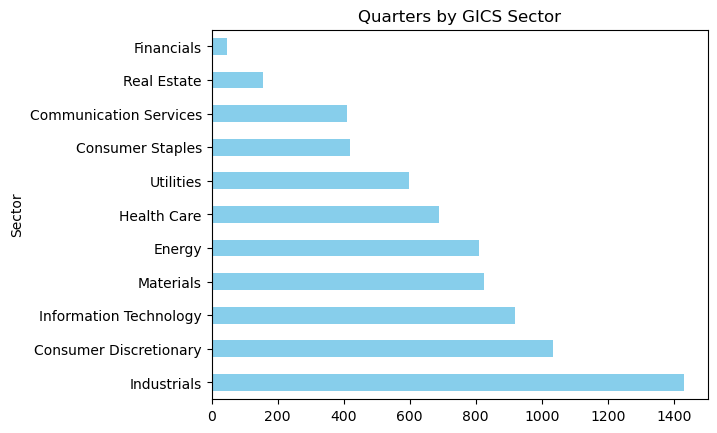

In [118]:
# Distribution of industry sectors
# variable sector
# Title: Calls in Each Industry Sector
df['Sector'].value_counts().plot(kind = 'barh', color = 'skyblue')
plt.title('Quarters by GICS Sector')
plt.savefig('../../../Output/all_data_fixed_quarter_dates_sector_distribution.png')
plt.show()

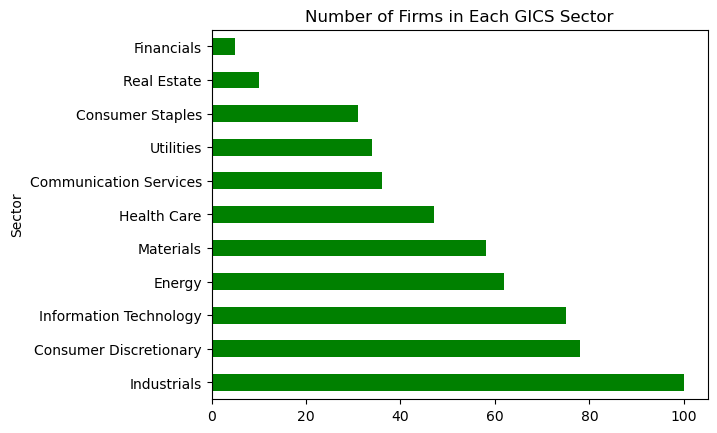

In [119]:
# Number of firms in each industry sector
# Title: Number of Firms in Each Industry Sector
# Unique ticker by sector, sort by number of firms
df.groupby('Sector')['ticker'].nunique().sort_values(ascending=False).plot(kind = 'barh', color = 'green')
plt.title('Number of Firms in Each GICS Sector')
plt.savefig('../../../Output/all_data_fixed_quarter_dates_firms_by_sector.png')
plt.show()

## Quarter Counts

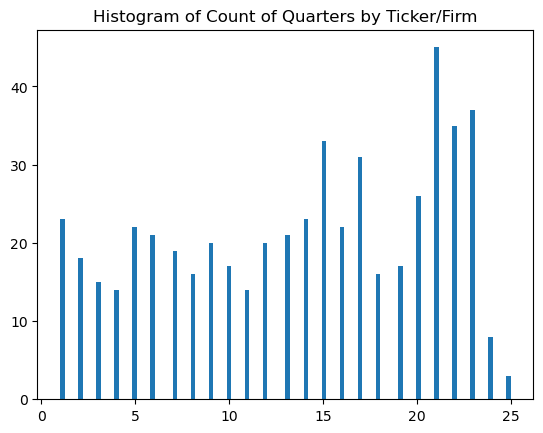

In [120]:
plt.hist(df['ticker'].value_counts(), bins = 100)
plt.title('Histogram of Count of Quarters by Ticker/Firm')
plt.savefig('../../../Output/all_data_fixed_quarter_dates_obs_by_ticker.png')
plt.show()

## Call Stats

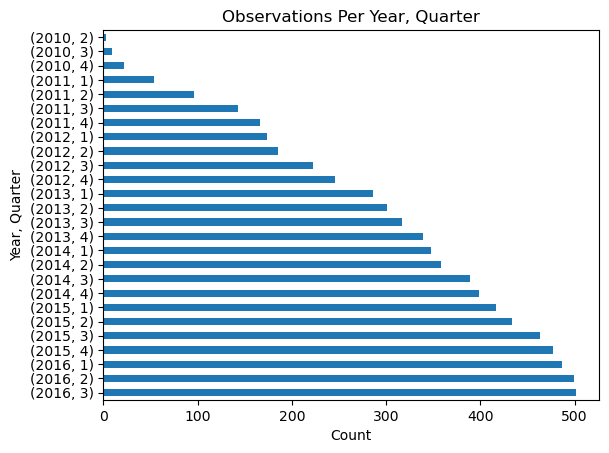

In [121]:
# Distribution of earnings_call_date year and quarter
# Create call_year and call_quarter columns after converting earnings_call_date to datetime
df['call_year'] = pd.to_datetime(df['earnings_call_date']).dt.year
df['call_quarter'] = pd.to_datetime(df['earnings_call_date']).dt.quarter
# Group by year and quarter
data_grouped = df.groupby([df.call_year, df.call_quarter]).size().sort_index(ascending=False)
# Plot horizontal bar chart
# 2010 at the top
data_grouped.plot(kind='barh')
plt.title('Observations Per Year, Quarter')
plt.xlabel('Count')
plt.ylabel('Year, Quarter')
plt.show()


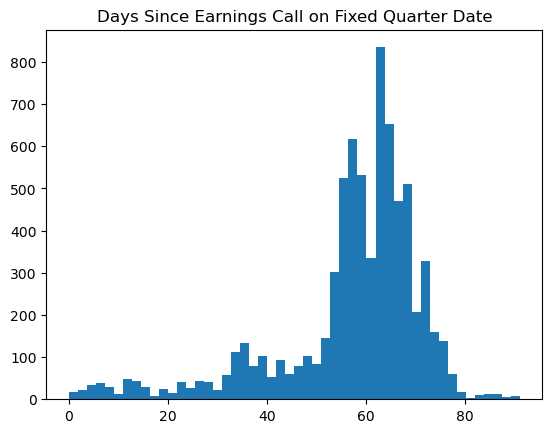

In [122]:
# Histogram of days_since_call
#credit_ratings_on_fixed_quarter_dates_with_earnings_call_date['days_since_call'].plot.hist(bins=50)
plt.hist(df['days_since_call'], bins=50)
plt.title('Days Since Earnings Call on Fixed Quarter Date')
plt.savefig('../../../Output/fixed_quarter_days_since_call_all_data.png')
plt.show()

## Overall Dates and Company Dropout

In [123]:
# For each ticker, get the max value of fixed_quarter_date, and print out items where it is not in the last quarter of 2016
# Convert fixed_quarter_date to datetime
df['fixed_quarter_date_dt'] = pd.to_datetime(df['fixed_quarter_date'])
# Add column max_date to df
df['max_date'] = df.groupby('ticker')['fixed_quarter_date_dt'].transform('max')
# Display rows where max_date is not in the last quarter of 2016
df[df['max_date'] < '2016-10-01']

,ticker,fixed_quarter_date,earnings_call_date,Rating,Rating Agency Name,rating_date,Source,Rating Rank AAA is 10,Next Rating,Next Rating Date,...,Sector,Industry Group,Industry,Sub-Industry,Comment,ticker_fixed_quarter_date,call_year,call_quarter,fixed_quarter_date_dt,max_date
189,ADSK,2013-10-01 00:00:00.000000,2013-08-22,BBB,Standard & Poor's Ratings Services,2013-08-20,Supplementary,7,BBB,2014-05-13,...,Information Technology,Software & Services,Software,Application Software,Companies engaged in developing and producing ...,ADSK_2013-10-01 00:00:00.000000,2013,3,2013-10-01,2016-04-01
190,ADSK,2014-01-01 00:00:00.000000,2013-11-21,BBB,Standard & Poor's Ratings Services,2013-08-20,Supplementary,7,BBB,2014-05-13,...,Information Technology,Software & Services,Software,Application Software,Companies engaged in developing and producing ...,ADSK_2014-01-01 00:00:00.000000,2013,4,2014-01-01,2016-04-01
191,ADSK,2014-04-01 00:00:00.000000,2014-02-26,BBB,Standard & Poor's Ratings Services,2013-08-20,Supplementary,7,BBB,2014-05-13,...,Information Technology,Software & Services,Software,Application Software,Companies engaged in developing and producing ...,ADSK_2014-04-01 00:00:00.000000,2014,1,2014-04-01,2016-04-01
192,ADSK,2014-07-01 00:00:00.000000,2014-05-16,BBB,Standard & Poor's Ratings Services,2014-05-13,Supplementary,7,None,None,...,Information Technology,Software & Services,Software,Application Software,Companies engaged in developing and producing ...,ADSK_2014-07-01 00:00:00.000000,2014,2,2014-07-01,2016-04-01
193,ADSK,2014-10-01 00:00:00.000000,2014-08-14,BBB,Standard & Poor's Ratings Services,2014-05-13,Supplementary,7,None,None,...,Information Technology,Software & Services,Software,Application Software,Companies engaged in developing and producing ...,ADSK_2014-10-01 00:00:00.000000,2014,3,2014-10-01,2016-04-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7187,WOR,2016-04-01 00:00:00.000000,2016-03-23,BBB,Standard & Poor's Ratings Services,2014-04-10,Supplementary,7,None,None,...,Materials,Materials,Metals & Mining,Steel,Producers of iron and steel and related produc...,WOR_2016-04-01 00:00:00.000000,2016,1,2016-04-01,2016-07-01
7188,WOR,2016-07-01 00:00:00.000000,2016-06-29,BBB,Standard & Poor's Ratings Services,2014-04-10,Supplementary,7,None,None,...,Materials,Materials,Metals & Mining,Steel,Producers of iron and steel and related produc...,WOR_2016-07-01 00:00:00.000000,2016,2,2016-07-01,2016-07-01
7241,XIN,2014-04-01 00:00:00.000000,2014-02-28,B,Standard & Poor's Ratings Services,2013-04-17,Original,5,B,2014-06-16,...,Real Estate,None,None,None,None,XIN_2014-04-01 00:00:00.000000,2014,1,2014-04-01,2016-04-01
7242,XIN,2015-04-01 00:00:00.000000,2015-02-27,B,Standard & Poor's Ratings Services,2014-11-17,Original,5,B,2016-08-24,...,Real Estate,None,None,None,None,XIN_2015-04-01 00:00:00.000000,2015,1,2015-04-01,2016-04-01


In [124]:
# Unique firms where this is the case
print(len(df[df['max_date'] < '2016-10-01'][['ticker', 'max_date']].drop_duplicates()))
df[df['max_date'] < '2016-10-01'][['ticker', 'max_date']].drop_duplicates()

35


,ticker,max_date
189,ADSK,2016-04-01
342,AMD,2016-07-01
678,BAH,2016-07-01
885,BTU,2016-04-01
968,CAG,2016-07-01
1351,CNHI,2016-04-01
1657,DAR,2016-07-01
1665,DELL,2016-07-01
1667,DEO,2015-10-01
1796,DRI,2016-07-01


Most are close which can be OK due to date inaccuracy

In [125]:
# Searching for some items in combined_calls.parquet
cc = pd.read_parquet('~\Box\STAT 222 Capstone\Intermediate Data\Calls\combined_calls.parquet', columns = ['symbol', 'date', 'source', 'year', 'quarter']).drop_duplicates()
cc[cc['symbol'] == 'AMD']

<>:2: SyntaxWarning: invalid escape sequence '\B'
<>:2: SyntaxWarning: invalid escape sequence '\B'
C:\Users\ijyli\AppData\Local\Temp\ipykernel_1744\826120937.py:2: SyntaxWarning: invalid escape sequence '\B'
  cc = pd.read_parquet('~\Box\STAT 222 Capstone\Intermediate Data\Calls\combined_calls.parquet', columns = ['symbol', 'date', 'source', 'year', 'quarter']).drop_duplicates()


,symbol,date,source,year,quarter
1654,AMD,2009-07-15,web,2010,1
1655,AMD,2009-10-14,web,2010,2
1656,AMD,2010-04-28,web,2010,4
1657,AMD,2010-10-14,web,2010,3
1658,AMD,2011-01-20,web,2011,3
1659,AMD,2011-04-21,web,2011,1
1660,AMD,2011-04-27,web,2011,4
1661,AMD,2011-07-20,web,2012,1
1662,AMD,2011-07-21,web,2011,2
1663,AMD,2011-10-19,web,2012,2


For AMD, there is a clear inaccuracy. looking up online their q2 2016 call was on 07/21/2016, web data is just wrong by a fair amount

yet we saw elsewhere for companies like nvidia - they really do report quarter and year results on a date before what you would expect for that quarter year

In [126]:
# items that are not close
print(len(df[df['max_date'] < '2016-07-01'][['ticker', 'max_date']].drop_duplicates()))
df[df['max_date'] < '2016-07-01'][['ticker', 'max_date']].drop_duplicates()

10


,ticker,max_date
189,ADSK,2016-04-01
885,BTU,2016-04-01
1351,CNHI,2016-04-01
1667,DEO,2015-10-01
4870,NVDA,2016-04-01
5855,SAIC,2016-04-01
6920,USM,2016-04-01
7013,VRNT,2016-04-01
7129,WFRD,2015-10-01
7241,XIN,2016-04-01


ADSK had their Q2 2016 earnings call on august 27, 2015 actually

BTU, peabody energy, seems to have gone bankrupt April 13, 2016

CNHI had a q2 call on july 26, 2016, not sure why problem

DEO appears to have had issues and not had calls

NVDA had their Q2 2016 earnings call august 6, 2016 actually

SAIC had their Q2 2016 earnings call september 1, 2015 actually

USM seems to have had Q2 2016 call in feb 2016 actually, probably some lag after

VRNT had Q2 2016 call in sep 2015 actually

WFRD unclear date

XIN had Q2 2016 call in august 2016, not sure why problem

So mostly concerned about CNHI, XIN

## Ratings

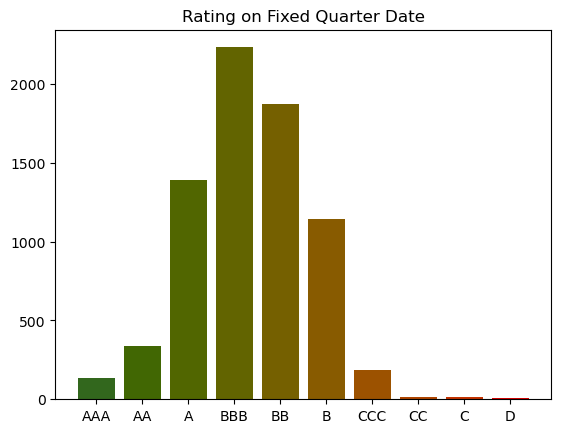

In [127]:
# Distribution of Rating and rating_on_next_earnings_call_date

# Colored with gradient and ordered

# Colors AAA through D
# Used https://colordesigner.io/gradient-generator#google_vignette
# Assign hex codes from green to red
#32671d
#416703
#516600
#626400
#756000
#885b00
#9c5200
#af4500
#c33200
#d60000
hex_code_mapper = {'AAA': '#32671d', 'AA': '#416703', 'A': '#516600', 'BBB': '#626400', 'BB': '#756000', 'B': '#885b00', 'CCC': '#9c5200', 'CC': '#af4500', 'C': '#c33200', 'D': '#d60000'}

# Ordering of bars - keys from hex_code_mapper
bar_order = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC', 'C', 'D']
# Assign values of Rating to this ordering
df['Rating'] = pd.Categorical(df['Rating'], categories=bar_order, ordered=True)

# Create plot
# Save to "../Output/Distribution of Ratings.png"
plt.bar(df['Rating'].value_counts().sort_index().index, df['Rating'].value_counts().sort_index(), color=[hex_code_mapper[i] for i in bar_order])
plt.title('Rating on Fixed Quarter Date')
#plt.savefig('../../Output/Distribution of Rating Issuances.png')
plt.show()

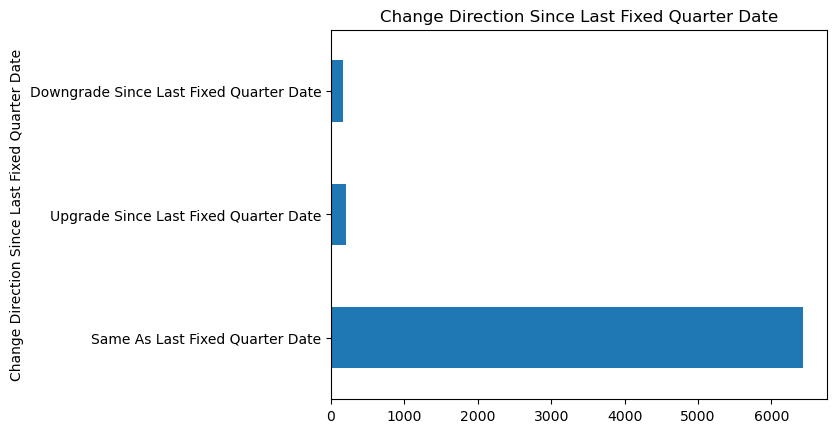

Change Direction Since Last Fixed Quarter Date
Same As Last Fixed Quarter Date            6433
Upgrade Since Last Fixed Quarter Date       199
Downgrade Since Last Fixed Quarter Date     166
Name: count, dtype: int64


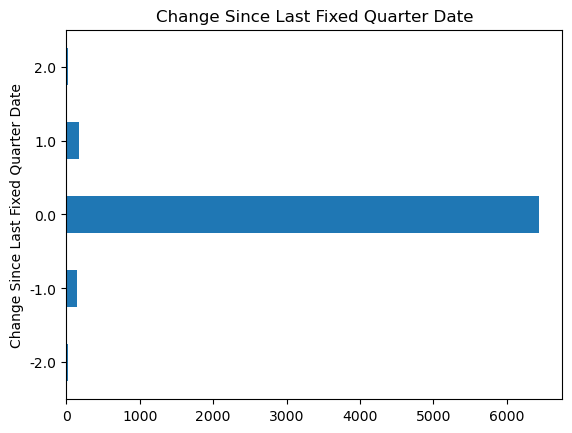

Change Since Last Fixed Quarter Date
-2.0      17
-1.0     149
 0.0    6433
 1.0     180
 2.0      19
Name: count, dtype: int64


In [128]:
df['Change Direction Since Last Fixed Quarter Date'].value_counts().plot(kind='barh')
plt.title('Change Direction Since Last Fixed Quarter Date')
plt.show()
print(df['Change Direction Since Last Fixed Quarter Date'].value_counts())

df['Change Since Last Fixed Quarter Date'].value_counts().sort_index().plot(kind='barh')
plt.title('Change Since Last Fixed Quarter Date')
plt.show()
print(df['Change Since Last Fixed Quarter Date'].value_counts().sort_index())


In [129]:
# Value counts of variable Investment_Grade
df['Investment_Grade'].value_counts()

Investment_Grade
True     4098
False    3236
Name: count, dtype: int64

## Financial Statement Data

C:\Users\ijyli\AppData\Local\Temp\ipykernel_1744\3119831694.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_assets_by_rating = df.groupby('Rating')['totalDebt'].mean()


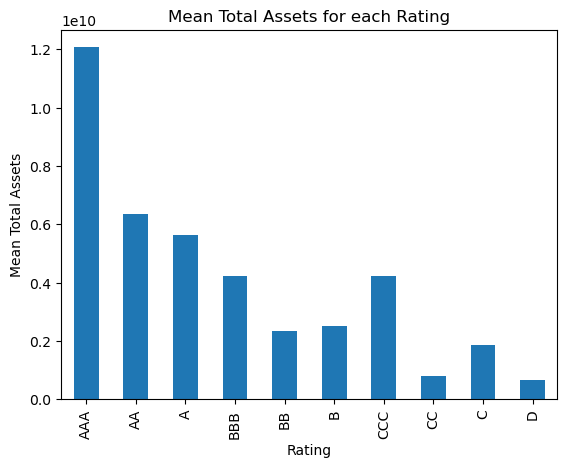

In [130]:
# Calculate the mean of "totalAssets" for each kind of "Rating"
mean_assets_by_rating = df.groupby('Rating')['totalDebt'].mean()

# Plotting
mean_assets_by_rating.plot(kind='bar')
plt.title('Mean Total Assets for each Rating')
plt.xlabel('Rating')
plt.ylabel('Mean Total Assets')
plt.show()

C:\Users\ijyli\AppData\Local\Temp\ipykernel_1744\796684613.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_gross_profit_by_rating = df.groupby('Rating')["grossProfitRatio"].mean()


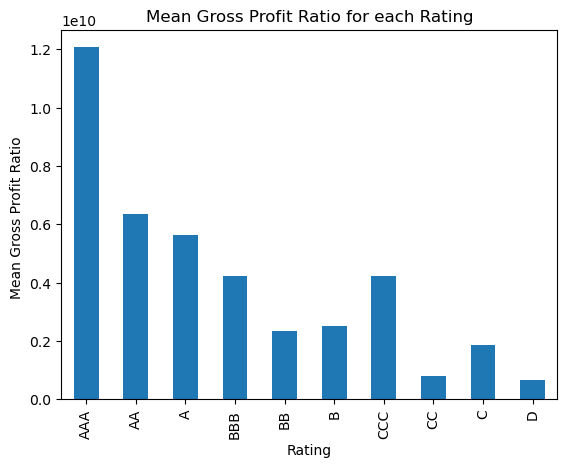

In [131]:
# Calculate the mean of "grossProfitRatio" for each kind of "Rating"
mean_gross_profit_by_rating = df.groupby('Rating')["grossProfitRatio"].mean()

# Plotting
mean_assets_by_rating.plot(kind='bar')
plt.title('Mean Gross Profit Ratio for each Rating')
plt.xlabel('Rating')
plt.ylabel('Mean Gross Profit Ratio ')
plt.show()

We can see the relationship between rating and total assets; rating and gross profit ratio. High rating like AAA will have high mean total assets and high mean gross profit ratio.

In [132]:
# Checking normalized average fianncial value to compare to the graph NN paper's table A.1
# Empty dataframe to store item, count, and percent_of_total_assets
table_a1_replication = pd.DataFrame(columns=['Item', 'Count', 'Percent_of_Total_Assets'])
# Compute average values of: totalAssets, currentLiabilities, totalLiabilities, totalEquity, retainedEarnings, currentAssets, netSales (revenue stand-in), EBIT (ebitda minus depreciation, etc),  market value of equity (commonStock + preferredStock stand-in), workingCapital, and Altman_Z
# Mean of total assets, removing missing and infinite values
total_assets_mean = df['totalAssets'].replace([np.inf, -np.inf], np.nan).dropna().mean()
# Loop over each variable
# Drop missing or infinite values
# Compute count and mean
for variable in ['totalAssets', 'totalCurrentLiabilities', 'totalLiabilities', 'totalEquity', 'retainedEarnings', 'totalCurrentAssets', 'revenue', 'EBIT', 'common_plus_preferred_stock', 'workingCapital']:
    var_count = df[variable].replace([np.inf, -np.inf], np.nan).dropna().count()
    var_mean = df[variable].replace([np.inf, -np.inf], np.nan).dropna().mean()
    table_a1_replication = pd.concat([table_a1_replication, pd.DataFrame({'Item': variable, 'Count': var_count, 'Percent_of_Total_Assets': 100*var_mean/total_assets_mean}, index=[0])])

table_a1_replication

C:\Users\ijyli\AppData\Local\Temp\ipykernel_1744\4236663331.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table_a1_replication = pd.concat([table_a1_replication, pd.DataFrame({'Item': variable, 'Count': var_count, 'Percent_of_Total_Assets': 100*var_mean/total_assets_mean}, index=[0])])


,Item,Count,Percent_of_Total_Assets
0,totalAssets,7259,100.000000
0,totalCurrentLiabilities,7258,18.830477
0,totalLiabilities,7258,61.412873
0,totalEquity,7334,33.644424
0,retainedEarnings,7334,21.894578
0,totalCurrentAssets,7259,26.955171
0,revenue,7170,17.810744
0,EBIT,7170,1.879150
0,common_plus_preferred_stock,7334,2.179639
0,workingCapital,7233,7.947861


In [133]:
# Average value of key ratios and altman Z
# use describe method, transpose, and print all rows
# round to two decimal places, no scientific notation, commas for thousands
pd.options.display.float_format = '{:,.2f}'.format
sum_stats_ratios = df[['Ratio_A', 'Ratio_B', 'Ratio_C', 'Ratio_D', 'Ratio_E', 'Altman_Z']].describe().T
sum_stats_ratios

,count,mean,std,min,25%,50%,75%,max
Ratio_A,"7,097.00",0.02,0.02,-0.02,0.01,0.02,0.03,0.08
Ratio_B,"7,097.00",0.21,0.15,0.04,0.10,0.18,0.27,0.73
Ratio_C,"6,817.00",2.76,7.27,0.19,0.81,1.44,2.45,62.47
Ratio_D,"7,233.00",0.13,0.15,-0.12,0.02,0.10,0.22,0.57
Ratio_E,"7,259.00",0.21,0.31,-0.64,0.00,0.19,0.39,1.02
Altman_Z,"6,648.00",2.36,4.24,-0.82,1.00,1.62,2.48,40.36
